In [29]:
import importlib
from volo_tools import volo_data
import numpy as np
import pandas as pd
from volo_tools import volo_feature_impl 
importlib.reload(volo_data)
importlib.reload(volo_feature_impl)
processor = volo_data.VoloDataProcessor()
processor.process("beta_project_data.csv")
print(processor.data.head())

Stocks with adjustment factor changes:
Symbol
AAPL      1510
CELG      1127
CMCS.A    1510
CRM        827
EOG       1067
GILD       771
GOOG       272
ICE       1510
KR        1390
LBTY.K    1047
MA        1019
NFLX      1391
NKE       1500
SBUX      1324
TSLA      1388
UAA       1077
UNP       1114
V         1310
dtype: int64


e:\voloridge\volo_tools\volo_data.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data['Date'] = pd.to_datetime(symbol_data['Date'], format='%m/%d/%Y')
e:\voloridge\volo_tools\volo_data.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data.sort_values(by='Date', inplace=True)
e:\voloridge\volo_tools\volo_data.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

         Code Symbol       Date  Close      Volume  Adjustment Factor  \
201690  59268   AABA  1/10/2011  16.60  16200000.0                1.0   
159708  59268   AABA  1/10/2012  15.51  14100000.0                1.0   
33121   59268   AABA  1/10/2013  18.99  30600000.0                1.0   
162596  59268   AABA  1/10/2014  41.23   8735111.0                1.0   
30664   59268   AABA  1/11/2010  16.74  16200000.0                1.0   

        Adj_Close  
201690      16.60  
159708      15.51  
33121       18.99  
162596      41.23  
30664       16.74  


In [30]:
# SHY, IEF, TLT proxy for yield curve
#
# BND, AGG, HYG
# HYG should be indicative of credit spreads
#

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

data_dir = "data"
graph_dir = os.path.join(data_dir, "graphs")
os.makedirs(graph_dir, exist_ok=True)

csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

all_betas = {}
symbol_std_list = []

for file in csv_files:
    try:
        df = pd.read_csv(file)
        if "Beta_45d" in df.columns:
            symbol = os.path.basename(file).replace("_data.csv", "")
            df = df.dropna(subset=["Beta_45d"])
            if len(df) == 0:
                continue

            all_betas[symbol] = df["Beta_45d"].values
            beta_std = df["Beta_45d"].std(skipna=True)
            symbol_std_list.append({"Symbol": symbol, "Beta_45d_STD": beta_std})
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Save std summary
beta_std_df = pd.DataFrame(symbol_std_list)
beta_std_df = beta_std_df.sort_values(by="Beta_45d_STD", ascending=True).reset_index(drop=True)
beta_std_df.to_csv("std_summary.csv", index=False, float_format="%.15f")

# Whisker (box) plot of all distributions
plt.figure(figsize=(max(10, len(all_betas) * 0.4), 6))
plt.boxplot(all_betas.values(), patch_artist=True, medianprops={"color": "black"},
            boxprops={"facecolor": "lightblue", "color": "blue"},
            whiskerprops={"color": "blue"}, capprops={"color": "blue"},
            flierprops={"marker": "o", "color": "red", "alpha": 0.5})

plt.xticks(range(1, len(all_betas) + 1), all_betas.keys(), rotation=90)
plt.ylabel("Beta_45d")
plt.title("Distribution of Beta_45d Across Stocks")
plt.grid(alpha=0.3)
plt.tight_layout()

whisker_plot_path = os.path.join(graph_dir, "beta_distribution_whisker.png")
plt.savefig(whisker_plot_path, dpi=300)
plt.close()

print(f"Whisker plot saved to {whisker_plot_path}")
print(beta_std_df)


Whisker plot saved to data\graphs\beta_distribution_whisker.png
    Symbol  Beta_45d_STD
0      SPY  2.005658e-15
1      SHY  1.764264e-02
2      IWB  1.954508e-02
3      IVV  2.178857e-02
4      VTI  3.346748e-02
..     ...           ...
197     GS  1.632579e+00
198    VIX  1.649295e+00
199   SPXU  1.999657e+00
200    VXX  2.086737e+00
201   UVXY  3.295913e+00

[202 rows x 2 columns]


In [32]:
importlib.reload(volo_feature_impl)
from sklearn.metrics import mean_squared_error, r2_score

train_window = 500
steps = 30
smoothing_window = 5

spy_data = pd.read_csv('data/SPY_data.csv')
spy_data.set_index("Date", inplace=True)
feature_processor = volo_feature_impl.VoloFeatureImpl()
spy, har_model = feature_processor._prepare_spy_baseline(spy_data, future_window=45)
spy.dropna(inplace=True)
spy["target_multiplier"] = spy["RV_future"]/spy["HAR_Pred"]
spy.to_csv('spy_target_sanity_check.csv')

#
avg_abs_diff = np.mean(np.abs(spy["RV_future"] - spy["HAR_Pred"]))
print(avg_abs_diff)
har_mse = mean_squared_error(spy["RV_future"], spy["HAR_Pred"])
har_r2 = r2_score(spy["RV_future"], spy["HAR_Pred"])
print(har_mse)
print(har_r2)

4.714457042187813e-05
7.392780974010755e-09
0.2588753471245846


C:\Users\likapichu\AppData\Local\Temp\ipykernel_40204\2718441541.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  spy_data["Date"] = pd.to_datetime(spy_data["Date"], errors="coerce", infer_datetime_format=True)


Average Absolute Difference: 4.714457042187813e-05
MSE: 7.392780974010755e-09
R²: 0.2588753471245846


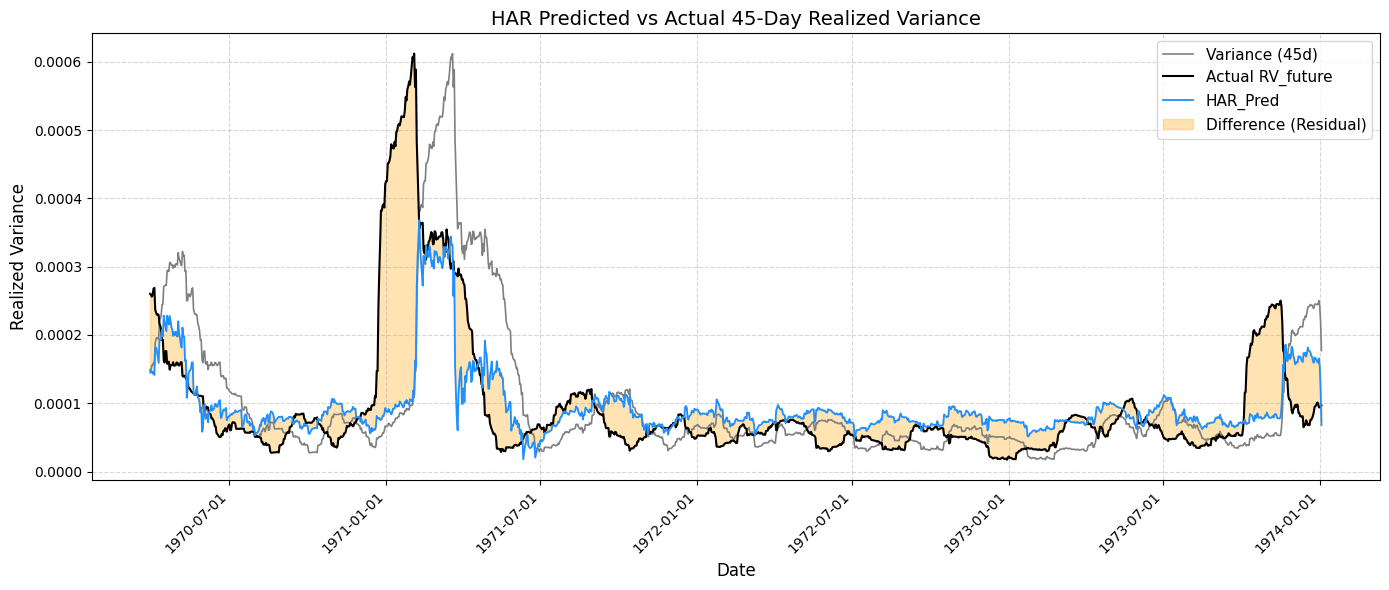

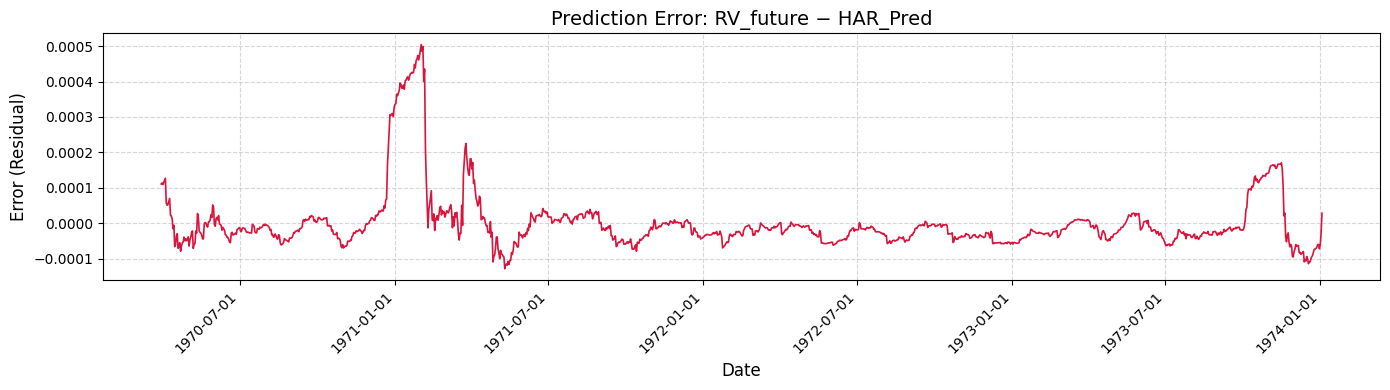

In [112]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import importlib
from sklearn.metrics import mean_squared_error, r2_score
from volo_tools import volo_feature_impl

importlib.reload(volo_feature_impl)

train_window = 500
steps = 30
smoothing_window = 5

# -----------------------------------
# Load and ensure proper datetime index
# -----------------------------------
spy_data = pd.read_csv('data/SPY_data.csv')

# Ensure proper datetime type before setting as index
spy_data["Date"] = pd.to_datetime(spy_data["Date"], errors="coerce", infer_datetime_format=True)
spy_data.dropna(subset=["Date"], inplace=True)
spy_data.sort_index(inplace=True)

# -----------------------------------
# Process features and model
# -----------------------------------
feature_processor = volo_feature_impl.VoloFeatureImpl()
spy, har_model = feature_processor._prepare_spy_baseline(spy_data, future_window=45)
spy.dropna(inplace=True)

spy["target_multiplier"] = spy["RV_future"] / spy["HAR_Pred"]
spy.to_csv('spy_target_sanity_check.csv')

avg_abs_diff = np.mean(np.abs(spy["RV_future"] - spy["HAR_Pred"]))
har_mse = mean_squared_error(spy["RV_future"], spy["HAR_Pred"])
har_r2 = r2_score(spy["RV_future"], spy["HAR_Pred"])

print("Average Absolute Difference:", avg_abs_diff)
print("MSE:", har_mse)
print("R²:", har_r2)

# -----------------------------------
# Plot HAR vs RV_future and difference
# -----------------------------------
plt.figure(figsize=(14, 6))
if "Variance_45d" in spy.columns:
    plt.plot(spy.index, spy["Variance_45d"], label="Variance (45d)", color="gray", linewidth=1.2)
plt.plot(spy.index, spy["RV_future"], label="Actual RV_future", color="black", linewidth=1.5)
plt.plot(spy.index, spy["HAR_Pred"], label="HAR_Pred", color="dodgerblue", linewidth=1.3)

plt.fill_between(spy.index, spy["RV_future"], spy["HAR_Pred"],
                 color="orange", alpha=0.3, label="Difference (Residual)")

plt.title("HAR Predicted vs Actual 45-Day Realized Variance", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Realized Variance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

# Proper date axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

# -----------------------------------
# Residual plot
# -----------------------------------
plt.figure(figsize=(14, 4))
plt.plot(spy.index, spy["RV_future"] - spy["HAR_Pred"], color="crimson", linewidth=1.2)
plt.title("Prediction Error: RV_future − HAR_Pred", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Error (Residual)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()
 

In [113]:
import pandas as pd
import os

def feature_collector(all_symbols, spy_path="data/SPY_data.csv"):
    
    data = spy.copy()

    for symbol in all_symbols:
        file_path = f"data/{symbol}_data.csv"
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping.")
            continue

        symbol_data = pd.read_csv(file_path)
        symbol_data = symbol_data.drop(columns=["Future_Beta_45d"], errors="ignore")
        symbol_data["Date"] = pd.to_datetime(symbol_data["Date"])

        # Merge on Date
        data = pd.merge(
            data,
            symbol_data,
            on="Date",
            how="outer",
            suffixes=("", f"_{symbol}")
        )

    data.sort_values("Date", inplace=True)
    data.reset_index(drop=True, inplace=True)
    #remove Future_Beta_45d
    data = data.loc[:, ~data.columns.str.contains('Future_Beta_45d')]
    data = data.loc[:, ~data.columns.str.contains('Code')]
    data = data.loc[:, ~data.columns.str.contains('RV_future')]
    data = data.loc[:, ~data.columns.str.contains('Symbol')]
    data = data.loc[:, ~data.columns.str.contains('Residual')]
    data.dropna(inplace=True)
        
    return data
# Get all csvs symbols with more than 1300 rows
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))


valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_variance = feature_collector(valid_symbols)
print(x_variance.head())
x_variance.to_csv("results/combined_features.csv", index=False)

          Date   Close       Volume  Adjustment Factor  Adj_Close  Log_Return  \
260 2011-01-14  129.30  118000000.0                1.0     129.30    0.007238   
261 2011-01-18  129.52  114000000.0                1.0     129.52    0.001700   
262 2011-01-19  128.25  152000000.0                1.0     128.25   -0.009854   
263 2011-01-20  128.08  176000000.0                1.0     128.08   -0.001326   
264 2011-01-21  128.37  151000000.0                1.0     128.37    0.002262   

     SPY_Return  Beta_45d  Variance_45d  Variance_45d_MA  ...  \
260    0.007238       1.0      0.000051          0.00006  ...   
261    0.001700       1.0      0.000051          0.00006  ...   
262   -0.009854       1.0      0.000050          0.00006  ...   
263   -0.001326       1.0      0.000050          0.00006  ...   
264    0.002262       1.0      0.000043          0.00006  ...   

     Adjustment Factor_XOP  Adj_Close_XOP  Log_Return_XOP  SPY_Return_XOP  \
260                    1.0          54.59    

In [38]:
import xgboost as xgb
def rolling_xgb(df, target_col="target_multiplier", train_window=500, step=5):
    if "Date" not in df.columns:
        if df.index.name == "Date":
            df = df.reset_index()
        else:
            raise ValueError("DataFrame must contain 'Date' column or have 'Date' as index name.")
    # Define features (exclude date and target)
    x_cols = [c for c in df.columns if c not in ["Date", target_col]]
    # remove any non-numeric columns from x_cols except date
    x_cols = [c for c in x_cols if pd.api.types.is_numeric_dtype(df[c]) and c != "Date"]
    preds, actuals, dates = [], [], []
    all_feature_importance = []

    # Check for GPU availability safely
    try:
        _ = xgb.DeviceQuantileDMatrix
        use_gpu = True
    except Exception:
        use_gpu = False

    for start in range(train_window, len(df) - step, step):
        train_set = df.iloc[start - train_window:start]
        test_set = df.iloc[start:start + step]

        X_train, y_train = train_set[x_cols], train_set[target_col]
        X_test, y_test = test_set[x_cols], test_set[target_col]

        # Safety: ensure no target col accidentally left in features
        X_train = X_train.drop(columns=["target_multiplier"], errors="ignore")
        X_test = X_test.drop(columns=["target_multiplier"], errors="ignore")

        # Model parameters
        params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

        # GPU acceleration if supported
        if use_gpu:
            params.update(tree_method="gpu_hist", predictor="gpu_predictor")
        else:
            params.update(tree_method="hist", predictor="cpu_predictor")

        model = xgb.XGBRegressor(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )

        # -----------------------------------------
        # Record feature importances for this window
        # -----------------------------------------
        imp = model.get_booster().get_score(importance_type="gain")
        imp_df = pd.DataFrame(list(imp.items()), columns=["Feature", "Gain"])
        imp_df["Window_Start"] = start
        all_feature_importance.append(imp_df)

        print(f"\nTop Features for window starting at {start}:")
        print(imp_df.sort_values("Gain", ascending=False).head(5).to_string(index=False))

        # Predict
        y_pred = model.predict(X_test)
        preds.extend(y_pred)
        actuals.extend(y_test.values)
        dates.extend(df["Date"].iloc[start:start + step].values)

    # Combine results
    result_df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Actual": actuals,
        "Predicted": preds
    }).sort_values("Date")
    result_df.set_index("Date", inplace=True)

    # -----------------------------------------
    # Aggregate global feature importances
    # -----------------------------------------
    if all_feature_importance:
        all_imp_df = pd.concat(all_feature_importance, ignore_index=True)
        all_imp_df.to_csv("results/feature_importances_SPY.csv", index=False, float_format="%.6f")
        global_imp = (
            all_imp_df.groupby("Feature")["Gain"]
            .mean()
            .sort_values(ascending=False)
            .reset_index()
        )
        print("\n=== Global Average Feature Importance (Gain) ===")
        print(global_imp.to_string(index=False))

    return result_df


# ============================================================
# Example usage
# ============================================================
pred_df_spy_var = rolling_xgb(x_variance)
print(pred_df_spy_var.head())
backup_spy_var = pred_df_spy_var.copy()

c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 500:
             Feature       Gain  Window_Start
 Variance_45d_MA_VXX 105.821472           500
Variance_45d_MA_REGN  29.453518           500
        Beta_45d_BAC  15.848585           500
  Variance_5d_MA_ICE  12.772277           500
 Variance_45d_MA_PEP  11.659426           500


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 505:
              Feature       Gain  Window_Start
  Variance_45d_MA_VXX 135.453674           505
 Variance_45d_MA_REGN  24.046312           505
            Close_DIS  15.877551           505
   Variance_5d_MA_WMB  12.591580           505
Variance_45d_MA_BRK.B  10.239291           505


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 510:
             Feature       Gain  Window_Start
 Variance_45d_MA_VXX 122.595268           510
Variance_45d_MA_REGN  24.443132           510
 Variance_45d_MA_IWM  13.406612           510
 Variance_45d_MA_IWB  10.736596           510
   Variance_45d_MA_C  10.413685           510


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 515:
             Feature      Gain  Window_Start
 Variance_45d_MA_VXX 96.924225           515
Variance_45d_MA_REGN 50.625156           515
  Variance_5d_MA_ICE 13.301584           515
  Variance_5d_MA_CMG 10.240695           515
   Variance_45d_MA_C  8.956137           515


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 520:
             Feature       Gain  Window_Start
 Variance_45d_MA_VXX 147.700714           520
Variance_45d_MA_REGN  49.496456           520
  Variance_5d_MA_ICE  24.200989           520
    Variance_45d_AGN  21.582485           520
   Variance_45d_MA_C  12.623238           520


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 525:
             Feature       Gain  Window_Start
 Variance_45d_MA_VXX 122.269966           525
Variance_45d_MA_REGN  43.632927           525
 Variance_45d_MA_WMT  36.686550           525
        Beta_45d_AXP  16.568260           525
   Variance_45d_MA_C  12.603152           525


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 530:
             Feature       Gain  Window_Start
 Variance_45d_MA_WMT 104.082031           530
 Variance_45d_MA_VXX  36.723080           530
    Variance_45d_AGN  22.966171           530
Variance_45d_MA_REGN  18.010015           530
  Variance_45d_MA_PG  12.903927           530


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 535:
            Feature       Gain  Window_Start
Variance_45d_MA_WMT 103.653542           535
Variance_45d_MA_MET  57.114410           535
Variance_45d_MA_VXX  32.634357           535
Variance_45d_MA_IWB  15.094770           535
Variance_45d_MA_SPG  14.534248           535


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 540:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 115.695068           540
Variance_45d_MA_WMT  95.944572           540
Variance_45d_MA_AGN  15.691468           540
Variance_45d_MA_IWB  13.913013           540
Variance_45d_MA_MET  13.529855           540


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 545:
            Feature       Gain  Window_Start
Variance_45d_MA_WMT 110.936790           545
Variance_45d_MA_VXX  85.850044           545
Variance_45d_MA_IWB  15.502136           545
 Variance_5d_MA_CVS  14.338371           545
Variance_45d_MA_VOO  12.457193           545


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 550:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 142.371170           550
Variance_45d_MA_WMT  41.133110           550
Variance_45d_MA_IWB  18.632580           550
Variance_45d_MA_MET  17.437218           550
 Variance_5d_MA_WMB  10.453010           550


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 555:
            Feature      Gain  Window_Start
Variance_45d_MA_VXX 94.269104           555
Variance_45d_MA_WMT 52.839001           555
Variance_45d_MA_SPG 30.099327           555
Variance_45d_MA_IVV 19.091274           555
Variance_45d_MA_IWB 16.080011           555


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 560:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 101.497124           560
Variance_45d_MA_WMT  48.512123           560
Variance_45d_MA_AGN  12.362785           560
Variance_45d_MA_IWB  12.165749           560
 Variance_5d_MA_WMB  10.671631           560


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 565:
            Feature      Gain  Window_Start
Variance_45d_MA_VXX 97.260582           565
Variance_45d_MA_WMT 51.674164           565
Variance_45d_MA_MET 37.381310           565
Variance_45d_MA_IWB 10.905773           565
       Beta_45d_XLI 10.711685           565


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 570:
              Feature      Gain  Window_Start
  Variance_45d_MA_VXX 97.167351           570
  Variance_45d_MA_WMT 47.977200           570
  Variance_45d_MA_IWB 23.727594           570
Variance_45d_MA_BRK.B 13.253982           570
         Beta_45d_XLI 12.758147           570


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 575:
              Feature       Gain  Window_Start
  Variance_45d_MA_VXX 104.046135           575
  Variance_45d_MA_WMT  59.200436           575
  Variance_45d_MA_IWB  16.441156           575
Variance_45d_MA_BRK.B  11.801424           575
         Beta_45d_FDX  11.118852           575


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 580:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 103.392159           580
Variance_45d_MA_WMT  47.503559           580
       Beta_45d_FDX  12.138563           580
    Variance_45d_KO   8.576267           580
Variance_5d_MA_ORCL   8.340668           580


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 585:
            Feature       Gain  Window_Start
Variance_45d_MA_VXX 105.528740           585
Variance_45d_MA_WMT  58.923016           585
Variance_5d_MA_ORCL  14.144527           585
Variance_45d_MA_IWB  13.726564           585
       Beta_45d_XLI  11.094491           585


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 590:
            Feature       Gain  Window_Start
          Close_TLT 169.970490           590
Variance_45d_MA_WMT 169.477295           590
Variance_45d_MA_VXX  88.388214           590
          Close_IEF  71.115280           590
Variance_45d_MA_MDY  26.013062           590


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 595:
            Feature       Gain  Window_Start
          Close_TLT 245.093155           595
          Close_EEM 237.889893           595
      Adj_Close_SLB 207.304123           595
Variance_45d_MA_WMT 174.308640           595
Variance_45d_MA_VXX 113.133995           595


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 600:
            Feature       Gain  Window_Start
          Close_TLT 193.426956           600
Variance_45d_MA_VXX 117.517204           600
Variance_45d_MA_MET  57.471722           600
Variance_45d_MA_WMT  34.910625           600
       Beta_45d_FDX  18.505470           600


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 605:
            Feature       Gain  Window_Start
          Close_TLT 128.633392           605
Variance_45d_MA_VXX  79.964119           605
          Close_HAL  67.147644           605
          Close_VWO  43.027386           605
  Variance_45d_MA_C  39.781155           605


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 610:
            Feature       Gain  Window_Start
          Close_TLT 339.676056           610
Variance_45d_MA_VXX  83.961426           610
Variance_5d_MA_NFLX  68.595490           610
       Beta_45d_FDX  19.285517           610
Variance_45d_MA_MDY  14.532842           610


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 615:
            Feature      Gain  Window_Start
Variance_5d_MA_NFLX 95.215416           615
          Close_IEF 80.213791           615
      Adj_Close_TLT 77.896019           615
          Close_TLT 74.616013           615
Variance_45d_MA_VXX 28.466249           615


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 620:
            Feature      Gain  Window_Start
Variance_45d_MA_VXX 58.142529           620
Variance_5d_MA_NFLX 57.216991           620
Variance_45d_MA_VOO 16.020578           620
       Beta_45d_KMB 12.474286           620
  Variance_5d_MA_KO 11.111050           620


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 625:
             Feature      Gain  Window_Start
Variance_45d_MA_ALXN 35.248127           625
     Beta_45d_TFCF.A 30.062782           625
 Variance_45d_MA_VXX 28.733894           625
         Beta_45d_CB 28.023455           625
Variance_45d_MA_AAPL 12.076925           625


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 630:
            Feature      Gain  Window_Start
       Beta_45d_AXP 32.763260           630
          Close_LLY 29.873535           630
Variance_45d_MA_WMB 16.446518           630
          Close_PEP 13.362896           630
      Adj_Close_PEP 12.031150           630


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 635:
            Feature      Gain  Window_Start
Variance_45d_MA_WMB 16.843760           635
Variance_45d_MA_IWB 12.949454           635
          Close_NKE 11.657167           635
Variance_5d_MA_ORCL 11.162439           635
       Beta_45d_KMB  8.809804           635


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 640:
              Feature     Gain  Window_Start
  Variance_45d_MA_IWB 9.041334           640
         Beta_45d_KMB 7.785943           640
Variance_45d_MA_BRK.B 7.721240           640
  Variance_45d_MA_TXN 7.263925           640
  Variance_45d_MA_WMB 6.644928           640


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 645:
            Feature      Gain  Window_Start
Variance_45d_MA_WMB 23.159142           645
       MA_5d_LBTY.K 12.525471           645
Variance_45d_MA_IWB 10.833794           645
Variance_5d_MA_ORCL  8.920882           645
      Adj_Close_PEP  7.461494           645


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 650:
            Feature      Gain  Window_Start
Variance_45d_MA_WMB 15.482869           650
Variance_45d_MA_IWB 13.242257           650
Variance_45d_MA_IJH 12.305618           650
Variance_5d_MA_ORCL  9.842030           650
       Beta_45d_KMB  9.065062           650


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 655:
              Feature      Gain  Window_Start
  Variance_45d_MA_WMB 15.463319           655
         Beta_45d_KMB 10.290154           655
  Variance_45d_MA_IWB  9.259163           655
Variance_45d_MA_BRK.B  8.697113           655
        Beta_45d_HEDJ  6.699332           655


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 660:
              Feature      Gain  Window_Start
  Variance_45d_MA_IWB 17.326050           660
     Variance_45d_DUK 10.675110           660
Variance_45d_MA_BRK.B  9.469374           660
        Adj_Close_PEP  8.778707           660
            Close_PEP  7.468251           660


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 665:
            Feature      Gain  Window_Start
Variance_45d_MA_IWB 12.328941           665
Variance_5d_MA_ORCL 10.631797           665
          Close_PEP  9.787608           665
       Beta_45d_KMB  8.965628           665
Variance_45d_MA_JNJ  7.524295           665


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 670:
            Feature      Gain  Window_Start
Variance_45d_MA_WMB 14.068038           670
          Close_PEP  8.562809           670
       Beta_45d_KMB  7.306552           670
      Adj_Close_PEP  7.255453           670
Variance_45d_MA_IWB  6.093926           670


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 675:
            Feature      Gain  Window_Start
          Close_PEP 16.030943           675
      Adj_Close_PEP 12.221185           675
Variance_5d_MA_ORCL  7.747952           675
   Variance_45d_DUK  6.030067           675
       Beta_45d_KMB  5.052083           675


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 680:
           Feature     Gain  Window_Start
      Beta_45d_KMB 7.849324           680
  Variance_45d_WMB 5.359127           680
      Beta_45d_BAC 4.726176           680
      Beta_45d_DUK 4.665772           680
Variance_5d_MA_DUK 3.979306           680


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 685:
         Feature     Gain  Window_Start
       Close_NKE 7.444876           685
    Beta_45d_BAC 6.255839           685
    Beta_45d_KMB 5.080248           685
      MA_45d_MON 3.827259           685
Variance_45d_DUK 3.531540           685


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 690:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 12.915523           690
  Variance_45d_CELG  7.538218           690
          Close_NKE  5.787429           690
   Variance_45d_DXJ  2.135536           690
       Beta_45d_BAC  1.957245           690


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 695:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 11.404363           695
          Close_NKE  7.285083           695
       Beta_45d_BAC  6.676037           695
   Variance_45d_DXJ  3.061364           695
 Variance_5d_MA_DUK  2.613401           695


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 700:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 10.667639           700
          Close_NKE  7.023594           700
  Variance_45d_CELG  6.573902           700
          MA_45d_BP  2.811437           700
 Variance_5d_MA_DUK  2.728451           700


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 705:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 10.660537           705
       Beta_45d_KMB  7.765681           705
          Close_NKE  7.110526           705
 Variance_5d_MA_EPD  2.753684           705
  Variance_45d_CELG  2.637752           705


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 710:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 13.696712           710
          Close_NKE  5.624891           710
  Variance_45d_CELG  3.573526           710
 Variance_5d_MA_EPD  2.809962           710
 Variance_5d_MA_DUK  1.879176           710


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 715:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 13.231572           715
         MA_45d_DIS  6.413145           715
          Close_NKE  5.958106           715
 Variance_5d_MA_EPD  2.624937           715
  Variance_45d_CELG  2.398550           715


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 720:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 10.842818           720
          Close_NKE  8.792014           720
       Beta_45d_BAC  4.509247           720
  Variance_45d_CELG  3.868577           720
 Variance_5d_MA_DUK  2.480242           720


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 725:
            Feature      Gain  Window_Start
Variance_5d_MA_CELG 12.922998           725
          Close_NKE  9.185709           725
   Variance_45d_DXJ  3.610908           725
 Variance_5d_MA_EPD  3.203043           725
         Close_AMLP  2.601708           725


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 730:
            Feature      Gain  Window_Start
          Close_JNJ 14.472551           730
Variance_5d_MA_CELG 12.635702           730
          Close_NKE  7.521742           730
Variance_5d_MA_AMLP  4.293983           730
Variance_45d_MA_WFC  3.619014           730


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 735:
           Feature      Gain  Window_Start
     Adj_Close_DUK 17.725710           735
         Close_DUK 12.007681           735
         Close_KMB  7.248781           735
         Close_WMT  6.522062           735
Variance_45d_MA_BK  4.272745           735


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 740:
            Feature     Gain  Window_Start
Variance_45d_MA_WFC 6.869369           740
          Close_KMB 6.644099           740
      Adj_Close_DUK 3.995058           740
Variance_5d_MA_AMLP 3.658195           740
 Variance_5d_MA_DUK 3.199112           740


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 745:
            Feature     Gain  Window_Start
Variance_45d_MA_WFC 9.201762           745
      Adj_Close_DUK 8.978683           745
          Close_WMT 8.482047           745
          Close_KMB 4.992666           745
          Close_DUK 4.345233           745


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 750:
            Feature      Gain  Window_Start
          Close_WMT 11.396602           750
          Close_DUK  6.455553           750
Variance_5d_MA_CELG  5.262531           750
          Close_KMB  4.148469           750
Variance_5d_MA_AMLP  3.322851           750


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 755:
            Feature     Gain  Window_Start
  Variance_45d_CELG 6.374364           755
Variance_5d_MA_CELG 3.640955           755
Variance_45d_MA_WFC 3.248637           755
          Close_KMB 3.174110           755
Variance_45d_MA_ICE 2.530009           755


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 760:
            Feature     Gain  Window_Start
  Variance_45d_CELG 3.656795           760
Variance_5d_MA_COST 1.845219           760
Variance_45d_MA_ABT 1.803514           760
   Variance_45d_LMT 1.586565           760
   Variance_45d_EPD 1.526484           760


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 765:
            Feature     Gain  Window_Start
  Variance_45d_CELG 3.197274           765
 Variance_5d_MA_DIA 2.996749           765
Variance_45d_MA_ABT 2.463671           765
   Variance_45d_LMT 1.678599           765
  Variance_45d_AMGN 1.493874           765


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 770:
            Feature     Gain  Window_Start
  Variance_45d_CELG 2.921491           770
   Variance_45d_LMT 2.564713           770
Variance_5d_MA_COST 1.279993           770
       Beta_45d_KMB 1.217013           770
   Variance_45d_DIA 1.168779           770


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 775:
            Feature     Gain  Window_Start
  Variance_45d_CELG 5.172793           775
   Variance_45d_LMT 2.020496           775
Variance_5d_MA_COST 1.457603           775
   Variance_45d_DIA 1.249323           775
Variance_45d_MA_WFC 1.002317           775


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 780:
           Feature     Gain  Window_Start
  Variance_45d_LMT 2.670596           780
 Variance_45d_CELG 2.631608           780
Variance_5d_MA_IBB 1.234974           780
  Variance_45d_DIA 1.205383           780
  Variance_45d_XLI 1.116701           780


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 785:
             Feature     Gain  Window_Start
Variance_45d_MA_COST 3.963643           785
  Variance_5d_MA_DIA 2.927951           785
   Variance_45d_CELG 2.626857           785
    Variance_45d_LMT 2.146668           785
    Variance_45d_DIA 1.578022           785


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 790:
             Feature     Gain  Window_Start
Variance_45d_MA_COST 4.027027           790
    Variance_45d_LMT 2.184836           790
  Variance_5d_MA_DIA 2.016788           790
   Variance_45d_CELG 1.625333           790
    Variance_45d_DIA 1.451428           790


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 795:
             Feature     Gain  Window_Start
  Variance_5d_MA_XLV 4.747660           795
Variance_45d_MA_COST 2.908506           795
    Variance_45d_LMT 2.245946           795
    Variance_45d_DIA 1.840146           795
    Variance_45d_XLV 1.387986           795


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 800:
           Feature     Gain  Window_Start
Variance_5d_MA_DIA 1.746687           800
  Variance_45d_LMT 1.509345           800
  Variance_45d_DIA 1.482231           800
 Variance_45d_CELG 1.404544           800
Variance_5d_MA_UTX 1.236367           800


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 805:
           Feature     Gain  Window_Start
Variance_5d_MA_LMT 8.203185           805
  Variance_45d_IBB 1.488096           805
  Variance_45d_XLV 1.460429           805
    Beta_45d_BRK.B 1.337613           805
  Variance_45d_XLI 1.312066           805


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 810:
           Feature     Gain  Window_Start
Variance_5d_MA_IBB 4.062975           810
  Variance_45d_XLV 1.816997           810
Variance_5d_MA_BHC 1.585695           810
  Variance_45d_IBB 1.363475           810
Variance_5d_MA_UTX 1.210505           810


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 815:
            Feature     Gain  Window_Start
 Variance_5d_MA_IBB 3.223738           815
Variance_5d_MA_AMLP 2.773001           815
   Variance_45d_IBB 2.059267           815
  Variance_45d_REGN 1.371538           815
        MA_45d_BIIB 1.258999           815


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 820:
           Feature     Gain  Window_Start
 Variance_45d_AMLP 2.646043           820
  Variance_45d_IBB 1.693544           820
  Variance_45d_XLY 1.485632           820
  Variance_45d_AMJ 1.443671           820
Variance_5d_MA_IWF 1.417958           820


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 825:
             Feature     Gain  Window_Start
    Variance_45d_XLY 2.226403           825
Variance_45d_MA_AAPL 1.702122           825
    Variance_45d_IBB 1.656805           825
  Variance_5d_MA_EPD 1.197028           825
    Variance_45d_XLV 1.046518           825


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 830:
           Feature     Gain  Window_Start
  Variance_45d_XLY 3.277870           830
  Variance_45d_AMJ 1.612887           830
  Variance_45d_IBB 1.419758           830
Variance_5d_MA_EPD 1.308604           830
 Variance_45d_AMLP 1.092276           830


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 835:
            Feature     Gain  Window_Start
        MA_45d_ESRX 2.999813           835
   Variance_45d_XLY 2.826718           835
   Variance_45d_IWF 1.642762           835
Variance_45d_MA_AIG 1.486371           835
 Variance_5d_MA_IBB 1.412568           835


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 840:
             Feature     Gain  Window_Start
    Variance_45d_XLY 2.973774           840
 Variance_45d_MA_UNH 1.973953           840
  Variance_5d_MA_EPD 1.153683           840
Variance_45d_MA_GILD 0.870844           840
  Variance_5d_MA_VXX 0.843586           840


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 845:
            Feature     Gain  Window_Start
   Variance_45d_XLY 2.627290           845
   Variance_45d_XLK 2.133577           845
Variance_45d_MA_UNH 2.032685           845
Variance_5d_MA_AMLP 1.620882           845
       Beta_45d_IWD 1.268296           845


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 850:
            Feature     Gain  Window_Start
Variance_45d_MA_UNH 2.109360           850
   Variance_45d_XLY 2.037883           850
       Beta_45d_SLB 1.733706           850
   Variance_45d_IWF 1.577532           850
 Variance_5d_MA_EPD 1.268148           850


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 855:
            Feature     Gain  Window_Start
Variance_45d_MA_UNH 2.047918           855
Variance_45d_MA_DOW 1.917156           855
       Beta_45d_SLB 1.826248           855
  Variance_45d_AMLP 1.724724           855
   Variance_45d_XLY 1.664837           855


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 860:
            Feature     Gain  Window_Start
Variance_5d_MA_AMLP 3.842822           860
       Beta_45d_SLB 2.712475           860
Variance_45d_MA_DOW 1.738323           860
Variance_45d_MA_UNH 1.443748           860
      Beta_45d_AMGN 0.886617           860


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 865:
            Feature     Gain  Window_Start
       Beta_45d_SLB 3.019375           865
Variance_5d_MA_AMLP 1.868291           865
Variance_45d_MA_DOW 1.850537           865
   Variance_45d_XLK 1.496565           865
      Beta_45d_AMGN 0.939822           865


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 870:
            Feature     Gain  Window_Start
       Beta_45d_SLB 3.032859           870
Variance_45d_MA_DOW 1.921948           870
Variance_45d_MA_CVS 1.751082           870
Variance_5d_MA_AMLP 1.319089           870
      Beta_45d_AMGN 1.253020           870


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 875:
            Feature     Gain  Window_Start
Variance_45d_MA_JNJ 1.760580           875
       Beta_45d_APC 1.756506           875
       Beta_45d_SLB 1.728594           875
      Beta_45d_AMGN 1.725350           875
  Variance_45d_AABA 1.684160           875


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 880:
            Feature     Gain  Window_Start
          MA_45d_HD 5.420852           880
       Beta_45d_APC 4.273124           880
Variance_45d_MA_JNJ 2.376999           880
 Variance_45d_MA_PG 1.646334           880
Variance_5d_MA_AMGN 1.438088           880


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 885:
            Feature     Gain  Window_Start
       Beta_45d_APC 3.255438           885
        MA_45d_ESRX 1.979664           885
 Variance_45d_MA_CB 1.576676           885
     Beta_45d_BRK.B 1.157334           885
Variance_5d_MA_AMGN 1.004441           885


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 890:
            Feature     Gain  Window_Start
       Beta_45d_APC 3.930544           890
 Variance_5d_MA_DIS 2.977183           890
Variance_5d_MA_AMGN 1.580245           890
   Variance_45d_CRM 1.562086           890
 Variance_45d_MA_CB 1.496524           890


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 895:
           Feature     Gain  Window_Start
      Beta_45d_APC 4.339759           895
     Beta_45d_REGN 3.368473           895
  Variance_45d_CRM 3.261380           895
Variance_5d_MA_CRM 2.293751           895
Variance_45d_MA_CB 2.037830           895


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 900:
              Feature     Gain  Window_Start
   Variance_5d_MA_CRM 2.995900           900
         Beta_45d_APC 2.971199           900
Variance_5d_MA_LBTY.K 1.920551           900
  Variance_5d_MA_AMGN 1.852783           900
     Variance_45d_CRM 1.772847           900


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 905:
            Feature     Gain  Window_Start
 Variance_45d_MA_MA 2.152087           905
   Variance_45d_CRM 2.081260           905
 Variance_5d_MA_CRM 1.885723           905
     Beta_45d_BRK.B 1.498960           905
Variance_45d_MA_HON 1.292058           905


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 910:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 2.466195           910
Variance_45d_MA_MA 2.390810           910
    Beta_45d_BRK.B 1.445030           910
        Close_ILMN 1.419881           910
      Beta_45d_SIG 1.013527           910


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 915:
              Feature     Gain  Window_Start
   Variance_5d_MA_CRM 4.440031           915
   Variance_45d_MA_MA 2.504132           915
         Beta_45d_FDX 1.509214           915
       Beta_45d_BRK.B 1.331040           915
Variance_5d_MA_LBTY.K 0.925760           915


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 920:
              Feature     Gain  Window_Start
Variance_5d_MA_LBTY.K 2.137458           920
       Beta_45d_BRK.B 2.074671           920
         Beta_45d_TWX 1.188258           920
     Variance_45d_CRM 1.123508           920
   Variance_5d_MA_KMB 0.972630           920


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 925:
              Feature     Gain  Window_Start
       Beta_45d_BRK.B 2.453594           925
   Variance_5d_MA_CRM 1.462177           925
         Beta_45d_TWX 1.414706           925
            Close_IVV 1.027837           925
Variance_5d_MA_LBTY.K 0.761623           925


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 930:
              Feature     Gain  Window_Start
       Beta_45d_BRK.B 2.514866           930
   Variance_5d_MA_CRM 1.692915           930
     Variance_45d_UNP 1.208403           930
Variance_5d_MA_LBTY.K 1.135127           930
            Close_IVV 0.991748           930


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 935:
              Feature     Gain  Window_Start
       Beta_45d_BRK.B 2.370284           935
   Variance_5d_MA_KMB 2.314850           935
            Close_CVX 1.674313           935
Variance_5d_MA_LBTY.K 1.299643           935
     Variance_45d_CRM 1.247935           935


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 940:
               Feature     Gain  Window_Start
        Beta_45d_BRK.B 2.729421           940
  Variance_45d_MA_GILD 2.408961           940
            MA_45d_BDX 1.764147           940
          Beta_45d_ICE 1.607236           940
Variance_45d_MA_LBTY.K 1.570227           940


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 945:
             Feature     Gain  Window_Start
         MA_45d_AMGN 6.111653           945
Variance_45d_MA_INTC 3.396976           945
          MA_45d_BDX 3.054722           945
  Variance_5d_MA_CRM 2.478314           945
      Beta_45d_BRK.B 2.187340           945


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 950:
           Feature     Gain  Window_Start
       MA_45d_AMGN 3.210192           950
Variance_5d_MA_CRM 2.764567           950
        Close_CSCO 2.430463           950
         MA_45d_HD 2.260606           950
         Close_XLY 1.878881           950


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 955:
           Feature     Gain  Window_Start
      Beta_45d_APC 4.796991           955
Variance_5d_MA_CRM 3.880702           955
         Close_IEF 2.475890           955
        MA_45d_EOG 2.409413           955
         MA_45d_HD 2.048782           955


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 960:
           Feature     Gain  Window_Start
      Beta_45d_APC 6.453466           960
Variance_5d_MA_CRM 3.573709           960
         Close_XLY 2.293912           960
    Adj_Close_INTC 1.705084           960
Variance_5d_MA_DIA 1.546294           960


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 965:
           Feature     Gain  Window_Start
      Beta_45d_APC 4.204563           965
    Adj_Close_UPRO 4.077482           965
Variance_5d_MA_CRM 3.906683           965
    Adj_Close_INTC 1.749856           965
      Beta_45d_XLV 1.721493           965


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 970:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 3.791347           970
        Close_EXPE 1.737728           970
  Variance_45d_CRM 1.385717           970
     Beta_45d_REGN 1.346577           970
     Beta_45d_ANDV 1.236840           970


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 975:
           Feature     Gain  Window_Start
        Close_EXPE 3.567349           975
Variance_5d_MA_CRM 3.424576           975
Variance_5d_MA_ICE 2.040147           975
  Adj_Close_TFCF.A 2.039468           975
     Beta_45d_REGN 1.996324           975


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 980:
            Feature     Gain  Window_Start
 Variance_5d_MA_ICE 4.162194           980
 Variance_5d_MA_CRM 3.128515           980
      Beta_45d_REGN 2.474704           980
Variance_5d_MA_AAPL 2.217219           980
   Variance_45d_CRM 1.753377           980


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 985:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 3.110747           985
     Beta_45d_REGN 2.845400           985
         Close_AIG 2.222455           985
Variance_5d_MA_ICE 1.868542           985
Variance_5d_MA_MDT 1.550792           985


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 990:
             Feature     Gain  Window_Start
  Variance_5d_MA_CRM 3.728376           990
  Variance_5d_MA_ICE 2.790706           990
 Variance_5d_MA_AAPL 2.199037           990
Variance_45d_MA_BIDU 1.837345           990
 Variance_45d_MA_OXY 1.733148           990


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 995:
            Feature     Gain  Window_Start
 Variance_5d_MA_CRM 4.803677           995
 Variance_5d_MA_ICE 4.678149           995
Variance_45d_MA_OXY 3.377109           995
       MA_45d_BRK.B 1.924727           995
Variance_5d_MA_AAPL 1.616057           995


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1000:
            Feature     Gain  Window_Start
 Variance_5d_MA_CRM 4.240193          1000
 Variance_5d_MA_ICE 2.833136          1000
Variance_45d_MA_OXY 2.556096          1000
Variance_5d_MA_AAPL 1.566766          1000
       Beta_45d_HYG 1.397671          1000


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1005:
            Feature     Gain  Window_Start
 Variance_5d_MA_CRM 2.598747          1005
Variance_5d_MA_AAPL 1.873672          1005
         MA_45d_PXD 1.714149          1005
   Variance_45d_ICE 1.657930          1005
   Variance_45d_CRM 1.620298          1005


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1010:
           Feature     Gain  Window_Start
Variance_5d_MA_CRM 3.271452          1010
Variance_5d_MA_ICE 2.823513          1010
        MA_45d_PXD 1.429936          1010
        MA_45d_EOG 1.370145          1010
          MA_45d_C 1.189735          1010


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1015:
              Feature     Gain  Window_Start
           MA_45d_PXD 3.427917          1015
   Variance_5d_MA_CRM 2.962705          1015
     Adj_Close_TFCF.A 1.503246          1015
   Variance_5d_MA_ICE 1.381992          1015
Variance_5d_MA_LBTY.K 1.314200          1015


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1020:
               Feature     Gain  Window_Start
             Close_GLD 3.971488          1020
    Variance_5d_MA_CRM 3.515151          1020
           MA_45d_AMGN 2.497399          1020
            MA_45d_PXD 1.780317          1020
Variance_45d_MA_LBTY.A 1.603425          1020


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1025:
            Feature     Gain  Window_Start
       Beta_45d_DIA 3.311378          1025
         MA_45d_PXD 2.520087          1025
 Variance_5d_MA_CRM 2.288338          1025
        MA_45d_AMGN 2.084814          1025
Variance_5d_MA_AAPL 1.473136          1025


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1030:
            Feature     Gain  Window_Start
         MA_45d_XOP 2.995727          1030
         MA_45d_PXD 2.789132          1030
 Variance_5d_MA_CRM 2.220043          1030
         MA_45d_QQQ 1.810407          1030
Variance_5d_MA_AAPL 1.805808          1030


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1035:
           Feature     Gain  Window_Start
Variance_45d_MA_MS 3.551068          1035
       MA_45d_AMGN 2.736379          1035
        MA_45d_PXD 2.419486          1035
Variance_5d_MA_CRM 1.935795          1035
Variance_5d_MA_LMT 1.733985          1035


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1040:
               Feature     Gain  Window_Start
    Variance_45d_MA_MS 3.852768          1040
   Variance_5d_MA_AAPL 3.135364          1040
            MA_45d_PXD 2.834752          1040
Variance_45d_MA_LBTY.A 1.682543          1040
            MA_45d_XOP 1.508596          1040


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1045:
           Feature     Gain  Window_Start
        MA_45d_PXD 2.654560          1045
Variance_45d_MA_MS 2.635620          1045
       MA_45d_AMGN 1.701956          1045
        MA_45d_XLK 1.437573          1045
    Beta_45d_BRK.B 1.409899          1045


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1050:
            Feature     Gain  Window_Start
 Variance_45d_MA_MS 2.660994          1050
         MA_45d_PXD 2.213351          1050
         Close_AVGO 1.947490          1050
Variance_45d_LBTY.K 1.226526          1050
Variance_5d_MA_AAPL 1.188743          1050


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1055:
            Feature     Gain  Window_Start
         MA_45d_PXD 2.885585          1055
         MA_45d_XLK 2.636477          1055
 Variance_45d_MA_MS 2.616903          1055
        MA_45d_TQQQ 1.393094          1055
Variance_45d_LBTY.K 0.996825          1055


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1060:
              Feature     Gain  Window_Start
   Variance_45d_MA_MS 3.192065          1060
  Variance_5d_MA_AAPL 3.100047          1060
           MA_45d_PXD 2.362690          1060
Variance_5d_MA_LBTY.K 1.130896          1060
          MA_45d_TQQQ 1.003605          1060


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1065:
               Feature     Gain  Window_Start
            MA_45d_PXD 2.549997          1065
    Variance_45d_MA_MS 2.521533          1065
   Variance_5d_MA_AAPL 1.308661          1065
Variance_45d_MA_LBTY.A 1.221094          1065
           MA_45d_TQQQ 0.948091          1065


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1070:
           Feature     Gain  Window_Start
Variance_45d_MA_MS 3.490048          1070
        MA_45d_SSO 2.367715          1070
        MA_45d_XOP 2.204265          1070
        MA_45d_PXD 2.155012          1070
       MA_45d_TQQQ 1.190815          1070


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1075:
           Feature     Gain  Window_Start
Variance_45d_MA_MS 2.824609          1075
        MA_45d_PXD 1.903800          1075
   Variance_45d_DD 0.999374          1075
  Variance_45d_AET 0.964303          1075
     Beta_45d_GILD 0.950444          1075


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1080:
           Feature     Gain  Window_Start
Variance_45d_MA_MS 4.509435          1080
        MA_45d_PXD 3.247869          1080
      Beta_45d_BLK 1.767556          1080
        MA_45d_XOP 1.379216          1080
         Close_BMY 1.215113          1080


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1085:
           Feature     Gain  Window_Start
     Adj_Close_EPD 9.529995          1085
      Beta_45d_VTI 8.257810          1085
         Close_EPD 5.151793          1085
Variance_45d_MA_MS 4.451139          1085
Variance_5d_MA_IEF 3.883923          1085


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1090:
             Feature      Gain  Window_Start
        Beta_45d_EWG 13.426258          1090
       Adj_Close_EPD 11.278263          1090
        Beta_45d_VTI  6.001322          1090
           Close_EPD  5.277807          1090
Variance_45d_MA_BKNG  4.884293          1090


c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\likapichu\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.c


Top Features for window starting at 1095:
            Feature      Gain  Window_Start
      Adj_Close_EPD 23.329651          1095
          Close_EPD 13.206645          1095
  Variance_5d_MA_MO  6.342590          1095
       Beta_45d_VTI  5.484118          1095
Variance_45d_MA_SSO  3.994177          1095

=== Global Average Feature Importance (Gain) ===
               Feature      Gain
   Variance_45d_MA_VXX 41.533623
   Variance_45d_MA_WMT 31.220978
             Close_TLT 15.920594
   Variance_45d_MA_IWB  7.992820
         Adj_Close_TLT  5.804267
  Variance_45d_MA_REGN  5.249253
   Variance_5d_MA_NFLX  4.884162
     Variance_45d_MA_C  3.775266
   Variance_5d_MA_CELG  3.399295
         Adj_Close_SLB  3.258179
 Variance_45d_MA_BRK.B  3.201097
             Close_EEM  3.003170
         Adj_Close_PEP  2.769303
   Variance_45d_MA_PEP  2.610970
             Close_DIS  2.593492
   Variance_45d_MA_MET  2.352077
          Beta_45d_KMB  2.236417
   Variance_5d_MA_ORCL  2.134544
             Clo

              Actual  Predicted
Date                           
2013-02-28  0.718880   0.656434
2013-03-01  0.725668   0.655517
2013-03-04  0.721402   0.697692
2013-03-05  0.687528   0.701218
2013-03-06  0.728697   0.743396
              Actual  Predicted  HAR_Pred
Date                                     
2013-02-28  0.718880   0.656434  0.000076
2013-03-01  0.725668   0.656128  0.000075
2013-03-04  0.721402   0.669983  0.000076
2013-03-05  0.687528   0.680395  0.000078
2013-03-06  0.728697   0.701395  0.000074
MSE: 0.052757 | R²: 0.7082 | MAPE: 20.28%


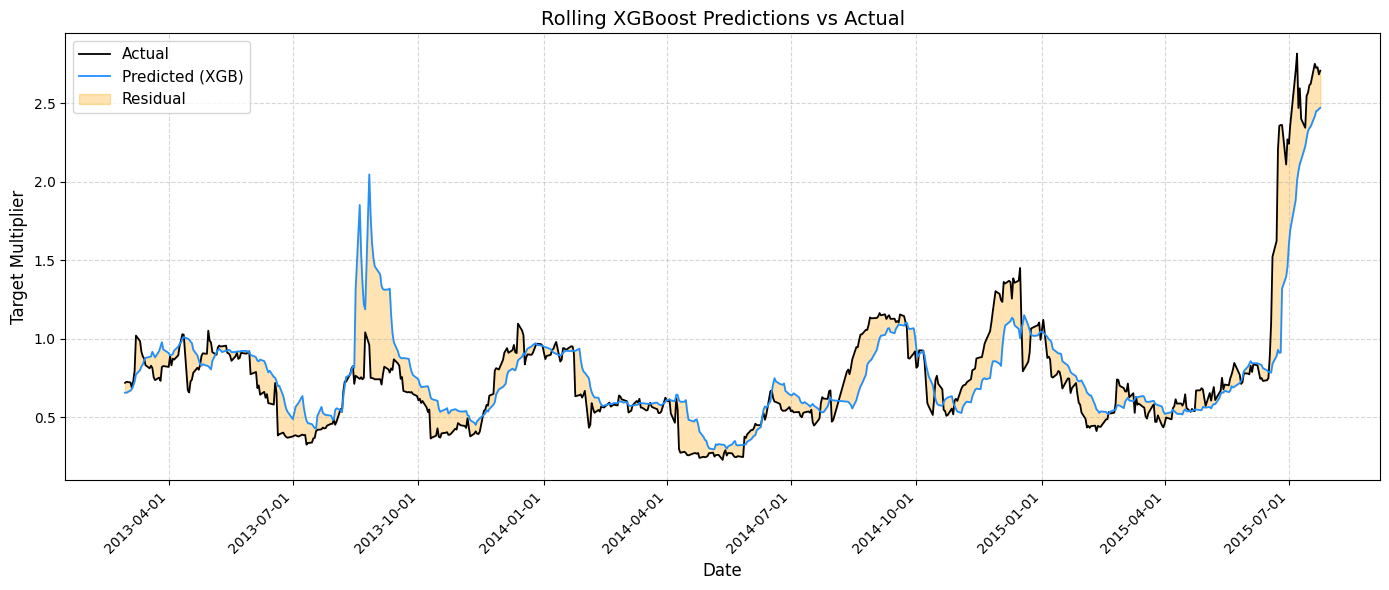

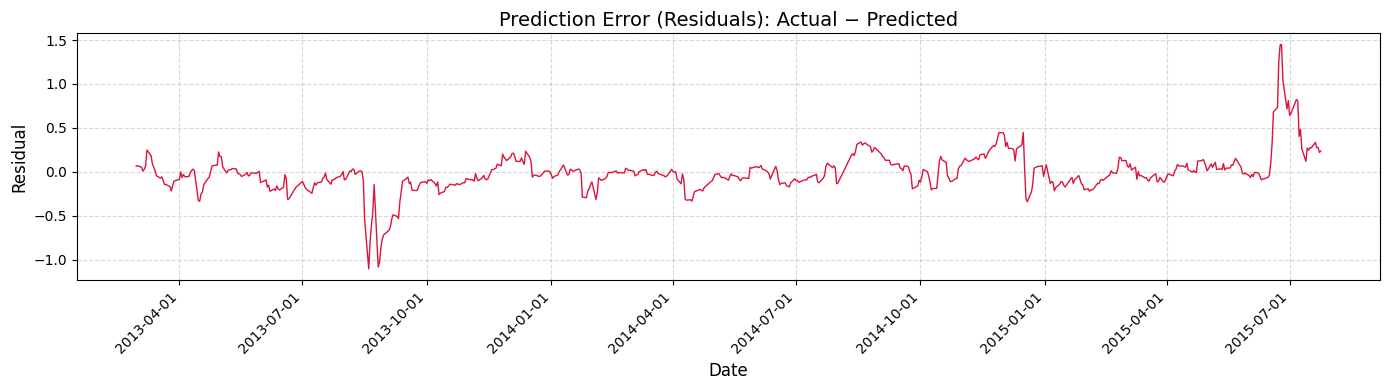

In [150]:
pred_df_spy_var = backup_spy_var.copy()
print(pred_df_spy_var.head())
#   Smooth predictions by exponential moving average
pred_df_spy_var["Predicted"] = pred_df_spy_var["Predicted"].ewm(span=5, adjust=False).mean()
# Check date of har_pred
# Index spy by Date

# Merge by date column
pred_df_spy_var = pred_df_spy_var.merge(
    spy[["HAR_Pred"]],
    left_index=True,
    right_index=True,
    how="left"
)



# Compute metrics
print(pred_df_spy_var.head())
mse = mean_squared_error(pred_df_spy_var["Actual"], pred_df_spy_var["Predicted"])
mape = np.mean(np.abs((pred_df_spy_var["Actual"] - pred_df_spy_var["Predicted"]) / pred_df_spy_var["Actual"])) * 100

r2 = r2_score(pred_df_spy_var["Actual"], pred_df_spy_var["Predicted"])
print(f"MSE: {mse:.6f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")


plt.figure(figsize=(14, 6))
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Actual"], label="Actual", color="black", linewidth=1.3)
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Predicted"], label="Predicted (XGB)", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    pred_df_spy_var.index,
    pred_df_spy_var["Actual"],
    pred_df_spy_var["Predicted"],
    color="orange",
    alpha=0.3,
    label="Residual"
)

plt.title("Rolling XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Target Multiplier", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(14, 4))
residuals = pred_df_spy_var["Actual"] - pred_df_spy_var["Predicted"]
plt.plot(pred_df_spy_var.index, residuals, color="crimson", linewidth=1)
plt.title("Prediction Error (Residuals): Actual − Predicted", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

              Actual  Predicted  HAR_Pred
Date                                     
2013-02-28  0.718880   0.656434  0.000076
2013-03-01  0.725668   0.656128  0.000075
2013-03-04  0.721402   0.669983  0.000076
2013-03-05  0.687528   0.680395  0.000078
2013-03-06  0.728697   0.701395  0.000074
              Actual  Predicted  HAR_Pred  HAR_Pred_spy
Date                                                   
2013-02-28  0.718880   0.656434  0.000076      0.000076
2013-03-01  0.725668   0.656128  0.000075      0.000075
2013-03-04  0.721402   0.669983  0.000076      0.000076
2013-03-05  0.687528   0.680395  0.000078      0.000078
2013-03-06  0.728697   0.701395  0.000074      0.000074
              Actual  Predicted  HAR_Pred  HAR_Pred_spy  Actual_SPY_Var  \
Date                                                                      
2013-02-28  0.718880   0.656434  0.000076      0.000076        0.000055   
2013-03-01  0.725668   0.656128  0.000075      0.000075        0.000055   
2013-03-04  0.

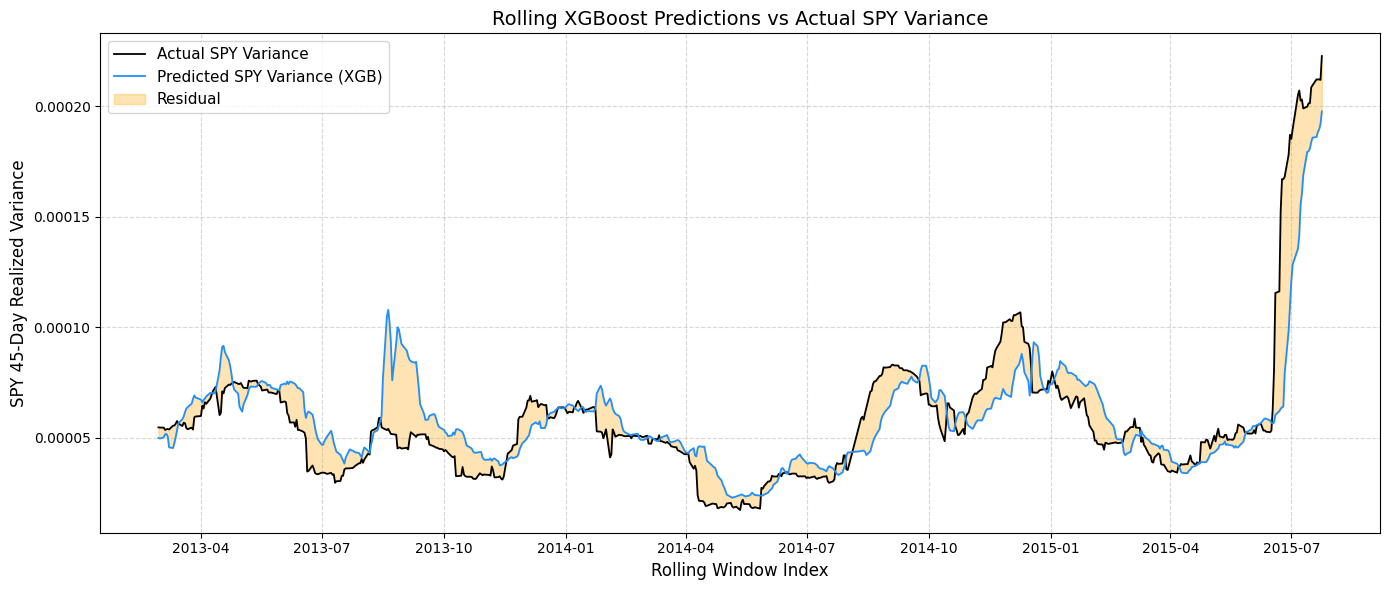

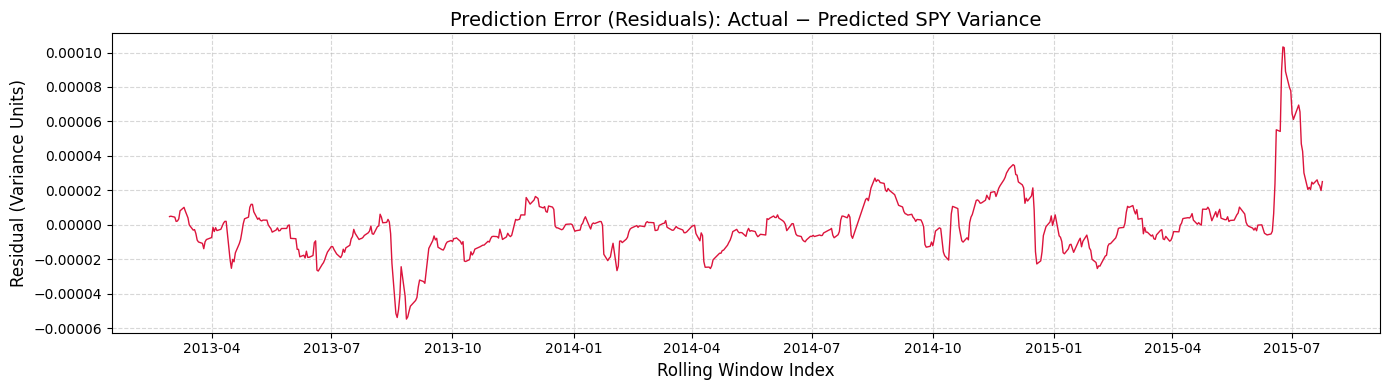

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ============================================================
# Convert predictions from multipliers to actual variance
# ============================================================

print(pred_df_spy_var.head())


# Assume spy_ref exists from HAR model (HAR_Pred column)
spy_ref = spy.copy()

pred_df_spy_var = pred_df_spy_var.merge(
    spy_ref[["HAR_Pred"]],
    left_index=True,
    right_index=True,
    how="left",
    suffixes=("", "_spy")
)

pred_df_spy_var.dropna(inplace=True)

print(pred_df_spy_var.head())

# Convert multiplier → actual variance
pred_df_spy_var["Actual_SPY_Var"] = pred_df_spy_var["Actual"] * pred_df_spy_var["HAR_Pred_spy"].values
pred_df_spy_var["Predicted_SPY_Var"] = pred_df_spy_var["Predicted"] * pred_df_spy_var["HAR_Pred_spy"].values

# Smooth predictions (optional)
pred_df_spy_var["Predicted_SPY_Var"] = pred_df_spy_var["Predicted_SPY_Var"].ewm(span=3, adjust=False).mean()

print(pred_df_spy_var.head())

# Compute metrics
mse = mean_squared_error(pred_df_spy_var["Actual_SPY_Var"], pred_df_spy_var["Predicted_SPY_Var"])
r2 = r2_score(pred_df_spy_var["Actual_SPY_Var"], pred_df_spy_var["Predicted_SPY_Var"])
print(f"MSE: {mse:.6f} | R²: {r2:.4f}")

# ============================================================
# Plot Actual vs Predicted SPY Variance (by window index)
# ============================================================
plt.figure(figsize=(14, 6))
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Actual_SPY_Var"], label="Actual SPY Variance", color="black", linewidth=1.3)
plt.plot(pred_df_spy_var.index, pred_df_spy_var["Predicted_SPY_Var"], label="Predicted SPY Variance (XGB)", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    pred_df_spy_var.index,
    pred_df_spy_var["Actual_SPY_Var"],
    pred_df_spy_var["Predicted_SPY_Var"],
    color="orange",
    alpha=0.3,
    label="Residual"
)

plt.title("Rolling XGBoost Predictions vs Actual SPY Variance", fontsize=14)
plt.xlabel("Rolling Window Index", fontsize=12)
plt.ylabel("SPY 45-Day Realized Variance", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ============================================================
# Residual Plot
# ============================================================
plt.figure(figsize=(14, 4))
residuals = pred_df_spy_var["Actual_SPY_Var"] - pred_df_spy_var["Predicted_SPY_Var"]
plt.plot(pred_df_spy_var.index, residuals, color="crimson", linewidth=1)
plt.title("Prediction Error (Residuals): Actual − Predicted SPY Variance", fontsize=14)
plt.xlabel("Rolling Window Index", fontsize=12)
plt.ylabel("Residual (Variance Units)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Covariance Calculation

In [189]:
from volo_tools import volo_feature_impl 
import importlib
import pandas as pd
import glob
import os
import numpy as np
importlib.reload(volo_feature_impl)
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

train_window = 500
steps = 30
smoothing_window = 5
def har_model(stock_name):
    # Load base datasets
    spy_data = pd.read_csv("data/SPY_data.csv", parse_dates=["Date"])
    spy_data.set_index("Date", inplace=True)

    stock_data = pd.read_csv(f"data/{stock_name}_data.csv", parse_dates=["Date"])
    stock_data.set_index("Date", inplace=True)

    feature_processor = volo_feature_impl.VoloFeatureImpl()

    # Separate covariances
    spy_stock_df, model_stock = feature_processor._prepare_spy_baseline_covar(
        spy_data, stock_data, stock_name, future_window=45
    )
    

    # Target variable = Future Covariance with stock
    spy_stock_df["target"] = spy_stock_df[f"Future_Cov_45_{stock_name}"]

   
    return spy_stock_df, model_stock


stock = "GM"
merged_df, har_model = har_model(stock)
print(merged_df.head())
print(merged_df['target'])

            Log_Return_SPY  Log_Return_GM  Cov_45_GM  Future_Cov_45_GM  \
Date                                                                     
2011-01-25        0.000542       0.019990   0.000015          0.000087   
2011-01-26        0.003863      -0.013370   0.000015          0.000088   
2011-01-27        0.002465       0.020377   0.000015          0.000091   
2011-01-28       -0.017617      -0.055016   0.000030          0.000070   
2011-01-31        0.007488      -0.003010   0.000028          0.000070   

            HAR_Pred_Cov_GM  Residual_Cov_GM    target  
Date                                                    
2011-01-25         0.000067         0.000021  0.000087  
2011-01-26         0.000066         0.000022  0.000088  
2011-01-27         0.000066         0.000025  0.000091  
2011-01-28         0.000074        -0.000004  0.000070  
2011-01-31         0.000073        -0.000004  0.000070  
Date
2011-01-25    0.000087
2011-01-26    0.000088
2011-01-27    0.000091
2011-01-

In [ ]:
import pandas as pd
import os

def feature_collector(all_symbols, spy_path="data/SPY_data.csv"):
    
    data = spy.copy()

    for symbol in all_symbols:
        file_path = f"data/{symbol}_data.csv"
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping.")
            continue

        symbol_data = pd.read_csv(file_path)
        symbol_data = symbol_data.drop(columns=["Future_Beta_45d"], errors="ignore")
        # Set date
        symbol_data["Date"] = pd.to_datetime(symbol_data["Date"])
        print(data)
        print(symbol_data)
        # Merge on Date
        data = pd.merge(
            data,
            symbol_data,
            on="Date",
            how="outer",
            suffixes=("", f"_{symbol}")
        )

    data.sort_values("Date", inplace=True)
    data.reset_index(drop=True, inplace=True)
    #remove Future_Beta_45d
    data = data.loc[:, ~data.columns.str.contains('Future_Beta_45d')]
    data = data.loc[:, ~data.columns.str.contains('Code')]
    data = data.loc[:, ~data.columns.str.contains('RV_future')]
    data = data.loc[:, ~data.columns.str.contains('Symbol')]
    data = data.loc[:, ~data.columns.str.contains('Residual')]
    data.dropna(inplace=True)
        
    return data
# Get all csvs symbols with more than 1300 rows
csv_files = glob.glob(os.path.join("data/", "*.csv"))


valid_symbols = [os.path.basename(f).replace("_data.csv", "") for f in csv_files if pd.read_csv(f).shape[0] > 1300]
x_covariance = feature_collector(valid_symbols)

Symbol = "GM"
# Add target
covar_var_merged = pd.merge(
    x_covariance,
    merged_df[[f"target"]],
    left_index=True,
    right_index=True,
    how="inner"
)
print(covar_var_merged['target'])

print(covar_var_merged.head())
covar_var_merged.to_csv("results/combined_features.csv", index=False)

             Code Symbol   Close       Volume  Adjustment Factor  Adj_Close  \
Date                                                                          
2010-05-12  59751    SPY  117.45  236000000.0                1.0     117.45   
2010-05-13  59751    SPY  115.99  234000000.0                1.0     115.99   
2010-05-14  59751    SPY  113.89  346000000.0                1.0     113.89   
2010-05-17  59751    SPY  113.95  326000000.0                1.0     113.95   
2010-05-18  59751    SPY  112.40  361000000.0                1.0     112.40   
...           ...    ...     ...          ...                ...        ...   
2015-10-21  59751    SPY  201.85  102000000.0                1.0     201.85   
2015-10-22  59751    SPY  205.26  175000000.0                1.0     205.26   
2015-10-23  59751    SPY  207.51  144000000.0                1.0     207.51   
2015-10-26  59751    SPY  207.00   69000000.0                1.0     207.00   
2015-10-27  59751    SPY  206.60   77900000.0       

In [188]:
import xgboost as xgb
def rolling_xgb(df, target_col="target", train_window=100, step=5):
    if "Date" not in df.columns:
        if df.index.name == "Date":
            df = df.reset_index()
        else:
            raise ValueError("DataFrame must contain 'Date' column or have 'Date' as index name.")
    # Define features (exclude date and target)
    # Add target
    
    x_cols = [c for c in df.columns if c not in ["Date", target_col]]
    # remove any non-numeric columns from x_cols except date
    x_cols = [c for c in x_cols if pd.api.types.is_numeric_dtype(df[c]) and c != "Date"]
    preds, actuals, dates = [], [], []
    all_feature_importance = []

    # Check for GPU availability safely
    try:
        _ = xgb.DeviceQuantileDMatrix
        use_gpu = True
    except Exception:
        use_gpu = False

    for start in range(train_window, len(df) - step, step):
        train_set = df.iloc[start - train_window:start]
        test_set = df.iloc[start:start + step]

        X_train, y_train = train_set[x_cols], train_set[target_col]
        X_test, y_test = test_set[x_cols], test_set[target_col]

        # Safety: ensure no target col accidentally left in features
        X_train = X_train.drop(columns=["target"], errors="ignore")
        X_test = X_test.drop(columns=["target"], errors="ignore")

        # Model parameters
        params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

        # GPU acceleration if supported
        if use_gpu:
            params.update(tree_method="gpu_hist", predictor="gpu_predictor")
        else:
            params.update(tree_method="hist", predictor="cpu_predictor")

        model = xgb.XGBRegressor(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )

        # -----------------------------------------
        # Record feature importances for this window
        # -----------------------------------------
        imp = model.get_booster().get_score(importance_type="gain")
        imp_df = pd.DataFrame(list(imp.items()), columns=["Feature", "Gain"])
        imp_df["Window_Start"] = start
        all_feature_importance.append(imp_df)

        print(f"\nTop Features for window starting at {start}:")
        print(imp_df.sort_values("Gain", ascending=False).head(5).to_string(index=False))

        # Predict
        y_pred = model.predict(X_test)
        preds.extend(y_pred)
        actuals.extend(y_test.values)
        dates.extend(df["Date"].iloc[start:start + step].values)

    # Combine results
    result_df = pd.DataFrame({
        "Date": pd.to_datetime(dates),
        "Actual": actuals,
        "Predicted": preds
    }).sort_values("Date")
    result_df.set_index("Date", inplace=True)

    # Aggregate global feature importances
    if all_feature_importance:
        all_imp_df = pd.concat(all_feature_importance, ignore_index=True)
        # save to csv
        all_imp_df.to_csv("results/feature_importances.csv", index=False, float_format="%.6f")
        global_imp = (
            all_imp_df.groupby("Feature")["Gain"]
            .mean()
            .sort_values(ascending=False)
            .reset_index()
        )
        print("\n=== Global Average Feature Importance (Gain) ===")
        print(global_imp.to_string(index=False))

    return result_df
print(x_covariance.head())
pred_df_covariance = rolling_xgb(x_covariance)
print(pred_df_covariance.head())
backup_covariance = pred_df_covariance.copy()

          Date   Close       Volume  Adjustment Factor  Adj_Close  Log_Return  \
260 2011-01-14  129.30  118000000.0                1.0     129.30    0.007238   
261 2011-01-18  129.52  114000000.0                1.0     129.52    0.001700   
262 2011-01-19  128.25  152000000.0                1.0     128.25   -0.009854   
263 2011-01-20  128.08  176000000.0                1.0     128.08   -0.001326   
264 2011-01-21  128.37  151000000.0                1.0     128.37    0.002262   

     SPY_Return  Beta_45d  Variance_45d  Variance_45d_MA  ...  \
260    0.007238       1.0      0.000051          0.00006  ...   
261    0.001700       1.0      0.000051          0.00006  ...   
262   -0.009854       1.0      0.000050          0.00006  ...   
263   -0.001326       1.0      0.000050          0.00006  ...   
264    0.002262       1.0      0.000043          0.00006  ...   

     Adjustment Factor_XOP  Adj_Close_XOP  Log_Return_XOP  SPY_Return_XOP  \
260                    1.0          54.59    

KeyError: 'target'

              Actual  Predicted
Date                           
2011-06-16  1.175395   1.120821
2011-06-17  1.171185   1.112871
2011-06-20  1.133484   1.114671
2011-06-21  1.142317   1.114450
2011-06-22  1.134802   1.109998
MSE: 0.022290 | R²: 0.8409 | MAPE: 8.08%


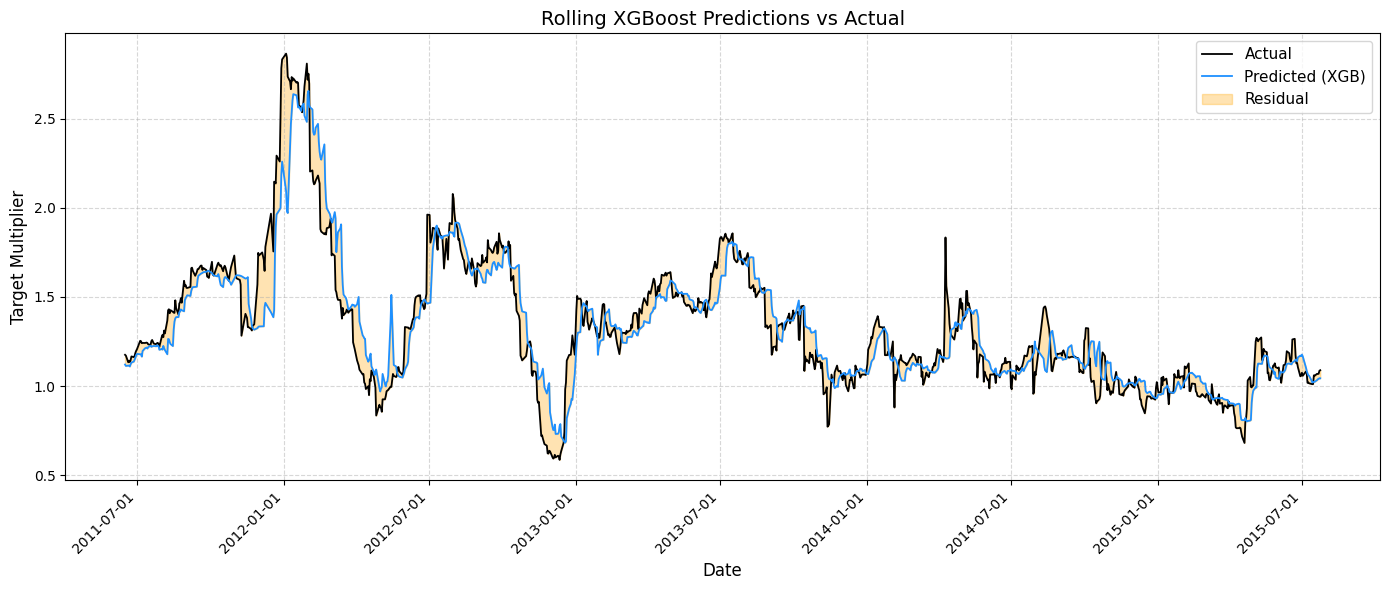

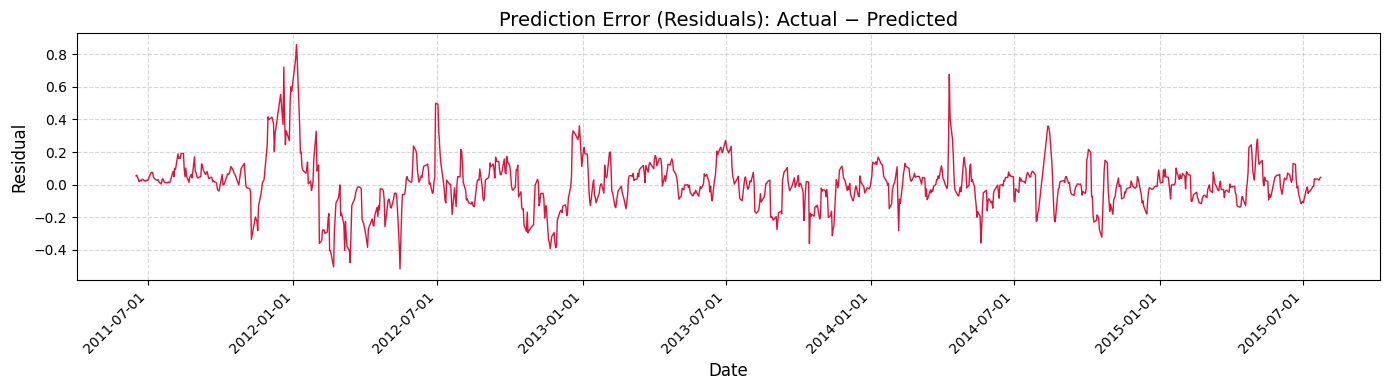

In [173]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pred_df_covariance = backup_covariance.copy()
#   Smooth predictions by exponential moving average
pred_df_covariance["Predicted"] = pred_df_covariance["Predicted"].ewm(span=3, adjust=False).mean()
# Compute metrics
print(pred_df_covariance.head())
mse = mean_squared_error(pred_df_covariance["Actual"], pred_df_covariance["Predicted"])
mape = np.mean(np.abs((pred_df_covariance["Actual"] - pred_df_covariance["Predicted"]) / pred_df_covariance["Actual"])) * 100

r2 = r2_score(pred_df_covariance["Actual"], pred_df_covariance["Predicted"])
print(f"MSE: {mse:.6f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")


plt.figure(figsize=(14, 6))
plt.plot(pred_df_covariance.index, pred_df_covariance["Actual"], label="Actual", color="black", linewidth=1.3)
plt.plot(pred_df_covariance.index, pred_df_covariance["Predicted"], label="Predicted (XGB)", color="dodgerblue", linewidth=1.3)
plt.fill_between(
    pred_df_covariance.index,
    pred_df_covariance["Actual"],
    pred_df_covariance["Predicted"],
    color="orange",
    alpha=0.3,
    label="Residual"
)

plt.title("Rolling XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Target Multiplier", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(14, 4))
residuals = pred_df_covariance["Actual"] - pred_df_covariance["Predicted"]
plt.plot(pred_df_covariance.index, residuals, color="crimson", linewidth=1)
plt.title("Prediction Error (Residuals): Actual − Predicted", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

              Actual  Predicted  Predicted_Covariance
Date                                                 
2011-06-16  1.175395   1.120821              1.120821
2011-06-17  1.171185   1.112871              1.112871
2011-06-20  1.133484   1.114671              1.114671
2011-06-21  1.142317   1.114450              1.114450
2011-06-22  1.134802   1.109998              1.109998
              Actual  Predicted  HAR_Pred  HAR_Pred_spy  Actual_SPY_Var  \
Date                                                                      
2013-02-28  0.718880   0.656434  0.000076      0.000076        0.000055   
2013-03-01  0.725668   0.656128  0.000075      0.000075        0.000055   
2013-03-04  0.721402   0.669983  0.000076      0.000076        0.000055   
2013-03-05  0.687528   0.680395  0.000078      0.000078        0.000054   
2013-03-06  0.728697   0.701395  0.000074      0.000074        0.000054   

            Predicted_SPY_Var  
Date                           
2013-02-28           0.000050  


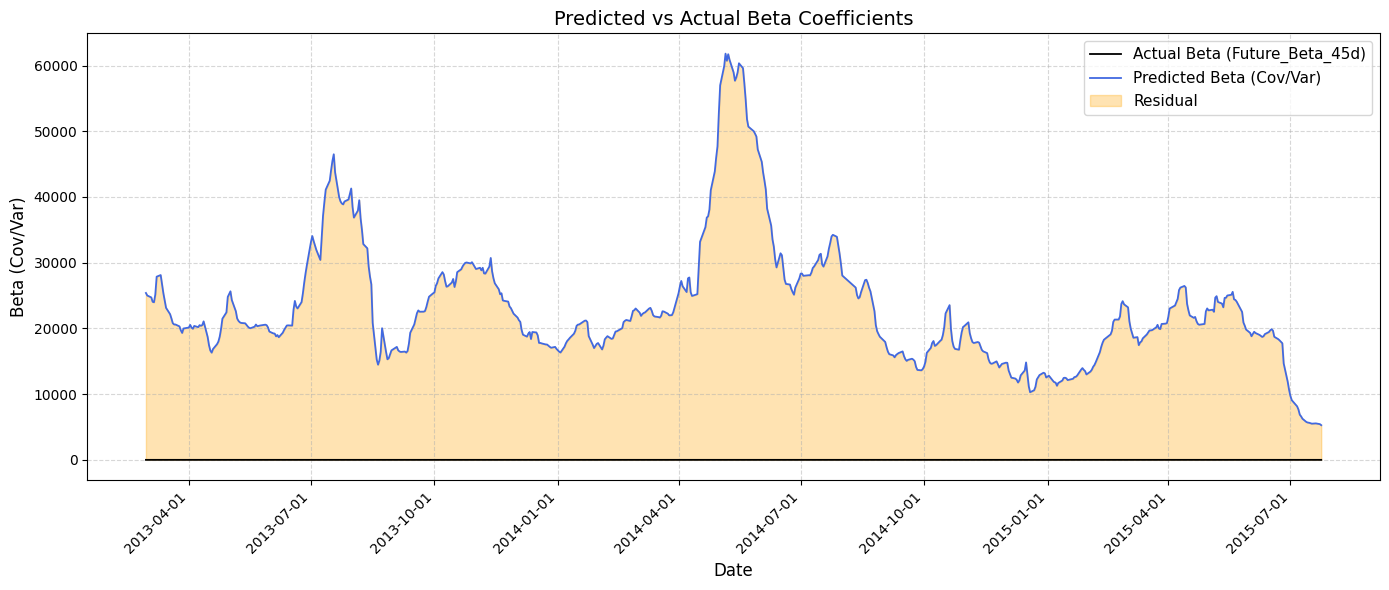


========== ERROR SUMMARY ==========
Mean Error (Bias): 23123.886095
Mean Absolute Error: 23123.886095
RMSE: 25041.189610
Std of Residuals: 9617.756376
Max Over-prediction: 61806.365946
Max Under-prediction: 5276.008869

Correlation (Pred vs Actual): 0.3445


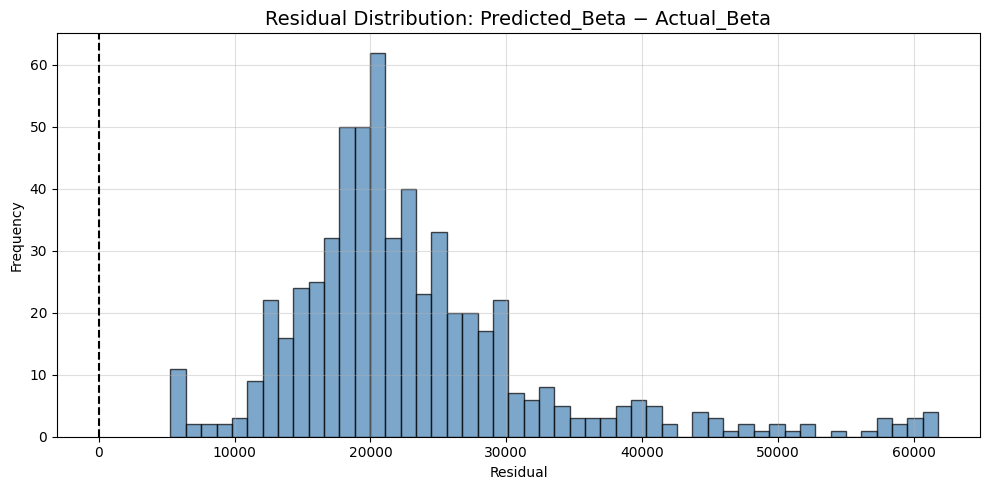

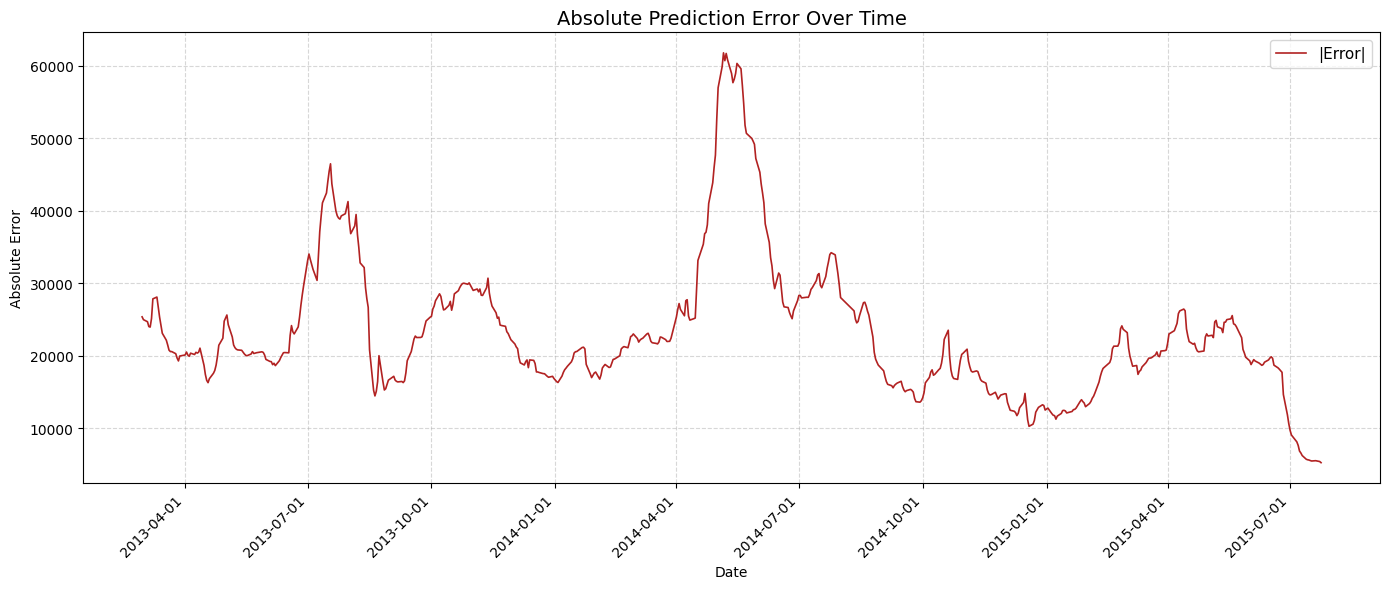

Top 10 Dates with Largest Absolute Errors:
            Future_Beta_45d  Predicted_Beta      Residual
Date                                                     
2014-05-06         1.533459    61807.899405  61806.365946
2014-05-08         1.453279    61721.348250  61719.894971
2014-05-09         1.466088    60862.633464  60861.167377
2014-05-07         1.534685    60723.587184  60722.052499
2014-05-16         1.255933    60344.746688  60343.490755
2014-05-05         1.391670    59905.929714  59904.538044
2014-05-19         1.234693    59604.488745  59603.254052
2014-05-15         1.205712    58956.039196  58954.833484
2014-05-12         1.407591    58950.934468  58949.526877
2014-05-14         1.279370    58181.332367  58180.052996


In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------
# 1. Sort input data
# ------------------------------------------------------------
pred_df_covariance_data = pred_df_covariance.sort_index()
pred_df_covariance_data['Predicted_Covariance'] = pred_df_covariance_data['Predicted']
pred_df_spy_var_data = pred_df_spy_var
print(pred_df_covariance_data.head())
print(pred_df_spy_var_data.head())
# ------------------------------------------------------------
# 2. Merge covariance + variance predictions first
# ------------------------------------------------------------
covar_var_merged = pd.merge(
    pred_df_covariance_data,
    pred_df_spy_var_data,
    # By Date column
    left_index=True,
    right_index=True,
    how="inner"
)
print(covar_var_merged.head())


# Compute predicted beta
covar_var_merged["Predicted_Beta"] = (
    covar_var_merged["Predicted_Covariance"] / pred_df_spy_var_data["Predicted_SPY_Var"]
)

print(covar_var_merged.head())
# ------------------------------------------------------------
# 3. Load AAPL actual beta data and align
# ------------------------------------------------------------
pred_df_actual = pd.read_csv("data/GM_data.csv", index_col=0, parse_dates=True)
pred_df_actual.index = pd.to_datetime(pred_df_actual.index, errors="coerce")
pred_df_actual = pred_df_actual.dropna(subset=["Future_Beta_45d"])

# Merge actual with predicted beta
merged_pred = pd.merge(
    pred_df_actual[["Future_Beta_45d"]],
    covar_var_merged[["Predicted_Beta"]],
    left_index=True,
    right_index=True,
    how="inner"
).dropna()
print("Merged Predictions Head:")
print(merged_pred.head())
# ------------------------------------------------------------
# 4. Evaluate model performance
# ------------------------------------------------------------
mse = mean_squared_error(merged_pred["Future_Beta_45d"], merged_pred["Predicted_Beta"])
r2 = r2_score(merged_pred["Future_Beta_45d"], merged_pred["Predicted_Beta"])
print(f"Beta Prediction — MSE: {mse:.6f} | R²: {r2:.4f}")

# ------------------------------------------------------------
# 5. Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(
    merged_pred.index,
    merged_pred["Future_Beta_45d"],
    label="Actual Beta (Future_Beta_45d)",
    color="black",
    linewidth=1.3
)
plt.plot(
    merged_pred.index,
    merged_pred["Predicted_Beta"],
    label="Predicted Beta (Cov/Var)",
    color="royalblue",
    linewidth=1.3
)
plt.fill_between(
    merged_pred.index,
    merged_pred["Future_Beta_45d"],
    merged_pred["Predicted_Beta"],
    color="orange",
    alpha=0.3,
    label="Residual"
)
plt.title("Predicted vs Actual Beta Coefficients", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Beta (Cov/Var)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
# ------------------------------------------------------------
# 6. Error Analytics
# ------------------------------------------------------------
merged_pred["Residual"] = merged_pred["Predicted_Beta"] - merged_pred["Future_Beta_45d"]
merged_pred["Abs_Error"] = merged_pred["Residual"].abs()
merged_pred["Squared_Error"] = merged_pred["Residual"] ** 2
merged_pred["Pct_Error"] = merged_pred["Residual"] / merged_pred["Future_Beta_45d"].replace(0, np.nan)

# ---- 6.1 Summary Statistics ----
print("\n========== ERROR SUMMARY ==========")
print(f"Mean Error (Bias): {merged_pred['Residual'].mean():.6f}")
print(f"Mean Absolute Error: {merged_pred['Abs_Error'].mean():.6f}")
print(f"RMSE: {np.sqrt(merged_pred['Squared_Error'].mean()):.6f}")
print(f"Std of Residuals: {merged_pred['Residual'].std():.6f}")
print(f"Max Over-prediction: {merged_pred['Residual'].max():.6f}")
print(f"Max Under-prediction: {merged_pred['Residual'].min():.6f}")
print("===================================\n")

# ---- 6.2 Correlation between Predicted and Actual ----
corr = merged_pred[["Future_Beta_45d", "Predicted_Beta"]].corr().iloc[0, 1]
print(f"Correlation (Pred vs Actual): {corr:.4f}")

# ---- 6.3 Residual Distribution ----
plt.figure(figsize=(10, 5))
plt.hist(merged_pred["Residual"], bins=50, color="steelblue", alpha=0.7, edgecolor="black")
plt.axvline(0, color="black", linestyle="--")
plt.title("Residual Distribution: Predicted_Beta − Actual_Beta", fontsize=14)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ---- 6.4 Time-Series of Absolute Error ----
plt.figure(figsize=(14, 6))
plt.plot(
    merged_pred.index,
    merged_pred["Abs_Error"],
    color="firebrick",
    linewidth=1.2,
    label="|Error|"
)
plt.title("Absolute Prediction Error Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=11)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---- 6.5 Identify Top Error Periods ----
top_errs = merged_pred.nlargest(10, "Abs_Error")[["Future_Beta_45d", "Predicted_Beta", "Residual"]]
print("Top 10 Dates with Largest Absolute Errors:")
print(top_errs)

In [ ]:
# IWB, IWD, IWF, IWM, IWN, IWR have near 1 beta compared to SPY